In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00


In [ ]:
#!pip install netCDF4 h5netcdf

In [ ]:
#!pip install xarray

In [2]:
# Install required packages
#!pip install xarray netCDF4 h5netcdf torch_geometric

import torch
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from torch_geometric.data import Data

from google.colab import drive
drive.mount('/content/drive')

# Load the NetCDF file
nc_file1 = "/content/drive/MyDrive/ERA5_datasets/data_accum.nc"
nc_file2 = "/content/drive/MyDrive/ERA5_datasets/data_instant.nc"
ds1 = xr.open_dataset(nc_file1)
ds2 = xr.open_dataset(nc_file2)

ds = xr.merge([ds1, ds2], compat='override')
print(ds)

# Extract variables and coordinates
lat = ds.latitude.values
lon = ds.longitude.values
time = ds.valid_time.values
variables = ['tp', 't2m', 'd2m', 'u10', 'v10', 'msl', 'tcwv', 'cape', 'slhf', 'sshf']
data = {var: ds[var].values for var in variables}
raw_tp = ds['tp'].values  # Keep raw tp in meters: [2160, 105, 237]

# Grid size and total nodes
N_time, N_lat, N_lon = data['tp'].shape
N_nodes = N_lat * N_lon

Mounted at /content/drive
<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2160, latitude: 105, longitude: 237)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 17kB 2025-01-01 ... 2025-03-31T23...
  * latitude    (latitude) float64 840B 50.0 49.75 49.5 ... 24.5 24.25 24.0
  * longitude   (longitude) float64 2kB -125.0 -124.8 -124.5 ... -66.25 -66.0
    expver      (valid_time) <U4 35kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 215MB ...
    slhf        (valid_time, latitude, longitude) float32 215MB ...
    sshf        (valid_time, latitude, longitude) float32 215MB ...
    u10         (valid_time, latitude, longitude) float32 215MB ...
    v10         (valid_time, latitude, longitude) float32 215MB ...
    d2m         (valid_time, latitude, longitude) float32 215MB ...
    t2m         (valid_time, latitude, longitude) float32 215MB ...
    msl         (valid_time, latitude, longitude) float32 215MB ...
  

In [3]:
# Step 1: Create Graph Structure (Edges based on 8-nearest neighbors)
def create_edge_index(N_lat, N_lon):
    edge_index = []
    for i in range(N_lat):
        for j in range(N_lon):
            node_idx = i * N_lon + j
            # Orthogonal edges (north, south, east, west)
            if i > 0:  # North
                edge_index.extend([[node_idx, (i-1) * N_lon + j], [(i-1) * N_lon + j, node_idx]])
            if i < N_lat-1:  # South
                edge_index.extend([[node_idx, (i+1) * N_lon + j], [(i+1) * N_lon + j, node_idx]])
            if j > 0:  # West
                edge_index.extend([[node_idx, i * N_lon + (j-1)], [i * N_lon + (j-1), node_idx]])
            if j < N_lon-1:  # East
                edge_index.extend([[node_idx, i * N_lon + (j+1)], [i * N_lon + (j+1), node_idx]])
            # Diagonal edges (northeast, northwest, southeast, southwest)
            if i > 0 and j < N_lon-1:  # Northeast
                edge_index.extend([[node_idx, (i-1) * N_lon + (j+1)], [(i-1) * N_lon + (j+1), node_idx]])
            if i > 0 and j > 0:  # Northwest
                edge_index.extend([[node_idx, (i-1) * N_lon + (j-1)], [(i-1) * N_lon + (j-1), node_idx]])
            if i < N_lat-1 and j < N_lon-1:  # Southeast
                edge_index.extend([[node_idx, (i+1) * N_lon + (j+1)], [(i+1) * N_lon + (j+1), node_idx]])
            if i < N_lat-1 and j > 0:  # Southwest
                edge_index.extend([[node_idx, (i+1) * N_lon + (j-1)], [(i+1) * N_lon + (j-1), node_idx]])
    return torch.tensor(edge_index, dtype=torch.long).t()

edge_index = create_edge_index(N_lat, N_lon)

# Normalize Features on Training Set
input_window = 12
target_window = 6
train_end = int(0.8 * N_time)  # 80% for training
train_times = range(input_window, train_end - target_window)

scalers = {var: StandardScaler() for var in variables}
for var in variables:
    train_data = data[var][train_times].reshape(-1, N_nodes)  # [~1713 timesteps, 24885]
    scalers[var].fit(train_data)  # Fit on training data
    data[var] = scalers[var].transform(data[var].reshape(N_time, -1)).reshape(N_time, N_lat, N_lon)  # Apply to all

# Step 3: Create Dataset Class for RAM Efficiency
from torch.utils.data import Dataset

class ERA5GraphDataset(Dataset):
    def __init__(self, data, raw_tp, input_window, target_window, edge_index, variables, normalize_per_window=False):
        self.data = data
        self.raw_tp = raw_tp
        self.input_window = input_window
        self.target_window = target_window
        self.edge_index = edge_index
        self.variables = variables
        self.normalize_per_window = normalize_per_window
        self.time_range = range(input_window, len(raw_tp) - target_window)

    def __len__(self):
        return len(self.time_range)

    def __getitem__(self, idx):
        t = self.time_range[idx]
        x = np.stack([self.data[var][t-self.input_window:t] for var in self.variables], axis=2)  # [12, N_lat, N_lon, 10]
        x = x.transpose(1, 2, 0, 3).reshape(N_nodes, -1)  # [N_nodes, 120]
        if self.normalize_per_window:
            scaler = StandardScaler()
            x = scaler.fit_transform(x)
        tp_future = self.raw_tp[t:t+self.target_window]  # [6, N_lat, N_lon]
        # Filter insignificant precipitation (<0.1 mm/hour = 0.0001 m)
        #tp_future = np.where(tp_future < 0.0001, 0, tp_future)
        # Sum and threshold at 1 mm (0.001 m)
        y = (tp_future.sum(axis=0) > 0.001).astype(int).ravel()  # [N_nodes]
        x_tensor = torch.tensor(x, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return Data(x=x_tensor, edge_index=self.edge_index, y=y_tensor)

# Create dataset (disable per-window normalization)
dataset = ERA5GraphDataset(data, raw_tp, input_window=12, target_window=6, edge_index=edge_index, variables=variables, normalize_per_window=False)

print(f"Processed {len(dataset)} samples for GNN training.")
print(f"Each sample: x={dataset[0].x.shape}, y={dataset[0].y.shape}, edge_index={dataset[0].edge_index.shape}")

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Temporal Split
from torch.utils.data import Subset

train_end = int(0.8 * len(dataset))  # ~1713
val_end = train_end + int(0.1 * len(dataset))  # ~1927
train_idx = list(range(0, train_end))
val_idx = list(range(train_end, val_end))
test_idx = list(range(val_end, len(dataset)))

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

rain_count = sum(dataset[i].y.sum().item() for i in train_idx)
total_nodes = sum(dataset[i].y.numel() for i in train_idx)
rain_percentage = (rain_count / total_nodes) * 100
print(f"Percentage of rain in training dataset: {rain_percentage:.2f}% (Rain nodes: {rain_count}, Total nodes: {total_nodes})")

# DataLoader
batch_sz = 16
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)



Processed 2142 samples for GNN training.
Each sample: x=torch.Size([24885, 120]), y=torch.Size([24885]), edge_index=torch.Size([2, 394064])
Percentage of rain in training dataset: 9.36% (Rain nodes: 3989613, Total nodes: 42628005)


In [6]:
# Define the Graph Neural Network Model
class GCNRainPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNRainPredictor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

input_dim = dataset[0].x.shape[1]  # 120
hidden_dim = 128
output_dim = 2

# Setup Loss Functions
class F1Loss(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(F1Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        probs = torch.softmax(inputs, dim=1)[:, 1]  # Probability of positive class (rain)
        targets = targets.float()

        true_positives = (probs * targets).sum()
        predicted_positives = probs.sum()
        actual_positives = targets.sum()

        precision = true_positives / (predicted_positives + self.epsilon)
        recall = true_positives / (actual_positives + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1_loss = 1 - f1  # Minimize 1 - F1 to maximize F1 score

        return f1_loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=1.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=1.0, class_weights=None):
        super(CombinedLoss, self).__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma, reduction='mean')
        self.ce = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
        self.f1 = F1Loss()

    def forward(self, inputs, targets):
        focal_loss = self.focal(inputs, targets)
        ce_loss = self.ce(inputs, targets)
        f1_loss = self.f1(inputs, targets)
        return 0.4 * focal_loss + 0.2 * ce_loss + 0.4 * f1_loss

# Training and Evaluation Functions
def train(model, train_loader, criterion, optimizer, epoch, accumulation_steps=4):
    model.train()
    optimizer = warmup_lr(optimizer, epoch)
    total_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    accumulated_loss = 0

    with tqdm(train_loader, desc=f'Epoch {epoch}', unit='batch') as t:
        for data in t:
            data = data.to(device)
            optimizer.zero_grad(set_to_none=True)  # Reset gradients
            out = model(data)
            loss = criterion(out, data.y) / accumulation_steps  # Scale loss
            loss.backward()  # Accumulate gradients
            accumulated_loss += loss.item() * accumulation_steps

            preds = out.argmax(dim=1)
            correct += (preds == data.y).sum().item()
            total += data.y.numel()
            batch_count += 1

            if batch_count % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)  # Clear gradients after step
                total_loss += accumulated_loss
                accumulated_loss = 0  # Reset accumulated loss
                t.set_postfix(loss=total_loss / (batch_count // accumulation_steps))
            else:
                t.set_postfix(loss=accumulated_loss)

    # Handle remaining gradients if batch_count is not divisible by accumulation_steps
    if batch_count % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += accumulated_loss

    avg_loss = total_loss / (batch_count // accumulation_steps + (1 if batch_count % accumulation_steps != 0 else 0))
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loader, true_rain_count, dataset_name="Test"):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            probs = torch.softmax(out, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    thresholds = np.linspace(0.05, 0.95, 20)
    best_threshold = 0.5
    min_diff = float('inf')
    for thresh in thresholds:
        preds = (np.array(all_probs) >= thresh).astype(int)
        pred_rain_count = sum(preds)
        diff = abs(pred_rain_count - true_rain_count)
        if diff < min_diff:
            min_diff = diff
            best_threshold = thresh

    all_preds = (np.array(all_probs) >= best_threshold).astype(int)

    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    pred_rain_count = sum(all_preds)

    # Per-class accuracy
    mask_class0 = np.array(all_labels) == 0
    mask_class1 = np.array(all_labels) == 1
    acc_class0 = accuracy_score(np.array(all_labels)[mask_class0], np.array(all_preds)[mask_class0]) if mask_class0.sum() > 0 else 0
    acc_class1 = accuracy_score(np.array(all_labels)[mask_class1], np.array(all_preds)[mask_class1]) if mask_class1.sum() > 0 else 0

    print(f"{dataset_name} - F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"{dataset_name} - Per-Class Accuracy: No Rain: {acc_class0:.4f}, Rain: {acc_class1:.4f}")
    print(f"{dataset_name} - Predicted Rain Nodes: {pred_rain_count}, True Rain Nodes: {true_rain_count}")
    print(f"{dataset_name} - Threshold: {best_threshold:.4f}")
    return f1, accuracy, all_probs, all_labels, acc_class0, acc_class1

# Learning rate warmup
def warmup_lr(optimizer, epoch, warmup_epochs=5, base_lr=0.0005):
    if epoch <= warmup_epochs:
        lr = base_lr * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer



In [7]:
# Train Model with Fixed Class Weights [1.0, 10.0]
num_epochs = 20
val_rain_count = sum(d.y.sum().item() for d in val_dataset)
test_rain_count = sum(d.y.sum().item() for d in test_dataset)

logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

class_weights = [1.0, 10.0]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

model = GCNRainPredictor(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = CombinedLoss(alpha=class_weights[1], gamma=1.0, class_weights=class_weights_tensor).to(device)

train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
val_f1_scores = []
test_f1_scores = []

best_test_f1 = 0.0
patience = 5
patience_counter = 0



for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_f1, val_acc, val_probs, val_labels, val_acc0, val_acc1 = evaluate(model, val_loader, val_rain_count, "Validation")
    val_f1_scores.append(val_f1)
    val_accuracies.append(val_acc)

    test_f1, test_acc, test_probs, test_labels, test_acc0, test_acc1 = evaluate(model, test_loader, test_rain_count, "Test")
    test_f1_scores.append(test_f1)
    test_accuracies.append(test_acc)

    log_msg = (f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
               f'Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}, Val Acc (No Rain): {val_acc0:.4f}, Val Acc (Rain): {val_acc1:.4f}, '
               f'Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}, Test Acc (No Rain): {test_acc0:.4f}, Test Acc (Rain): {test_acc1:.4f}')
    logger.info(log_msg)
    print(log_msg)

    scheduler.step(test_f1)

    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_GCN_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=8.09]


Validation - F1: 0.1703, Accuracy: 0.8380, Precision: 0.2110, Recall: 0.1428
Validation - Per-Class Accuracy: No Rain: 0.9296, Rain: 0.1428
Validation - Predicted Rain Nodes: 419660, True Rain Nodes: 620015
Validation - Threshold: 0.5711
Test - F1: 0.1867, Accuracy: 0.7770, Precision: 0.1729, Recall: 0.2029
Test - Per-Class Accuracy: No Rain: 0.8599, Rain: 0.2029
Test - Predicted Rain Nodes: 792018, True Rain Nodes: 674917
Test - Threshold: 0.5237
Epoch 01, Train Loss: 8.0880, Train Acc: 0.5531, Val F1: 0.1703, Val Acc: 0.8380, Val Acc (No Rain): 0.9296, Val Acc (Rain): 0.1428, Test F1: 0.1867, Test Acc: 0.7770, Test Acc (No Rain): 0.8599, Test Acc (Rain): 0.2029


Epoch 2: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=6.08]


Validation - F1: 0.2252, Accuracy: 0.7865, Precision: 0.1949, Recall: 0.2665
Validation - Per-Class Accuracy: No Rain: 0.8550, Rain: 0.2665
Validation - Predicted Rain Nodes: 847471, True Rain Nodes: 620015
Validation - Threshold: 0.3816
Test - F1: 0.2073, Accuracy: 0.7794, Precision: 0.1896, Recall: 0.2288
Test - Per-Class Accuracy: No Rain: 0.8589, Rain: 0.2288
Test - Predicted Rain Nodes: 814302, True Rain Nodes: 674917
Test - Threshold: 0.3816
Epoch 02, Train Loss: 6.0835, Train Acc: 0.7866, Val F1: 0.2252, Val Acc: 0.7865, Val Acc (No Rain): 0.8550, Val Acc (Rain): 0.2665, Test F1: 0.2073, Test Acc: 0.7794, Test Acc (No Rain): 0.8589, Test Acc (Rain): 0.2288


Epoch 3: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=5.07]


Validation - F1: 0.2309, Accuracy: 0.8189, Precision: 0.2283, Recall: 0.2336
Validation - Per-Class Accuracy: No Rain: 0.8960, Rain: 0.2336
Validation - Predicted Rain Nodes: 634260, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2345, Accuracy: 0.8162, Precision: 0.2470, Recall: 0.2232
Test - Per-Class Accuracy: No Rain: 0.9018, Rain: 0.2232
Test - Predicted Rain Nodes: 609849, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 03, Train Loss: 5.0723, Train Acc: 0.8885, Val F1: 0.2309, Val Acc: 0.8189, Val Acc (No Rain): 0.8960, Val Acc (Rain): 0.2336, Test F1: 0.2345, Test Acc: 0.8162, Test Acc (No Rain): 0.9018, Test Acc (Rain): 0.2232


Epoch 4: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.91]


Validation - F1: 0.1883, Accuracy: 0.8512, Precision: 0.2581, Recall: 0.1482
Validation - Per-Class Accuracy: No Rain: 0.9439, Rain: 0.1482
Validation - Predicted Rain Nodes: 356070, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2334, Accuracy: 0.7871, Precision: 0.2138, Recall: 0.2568
Test - Per-Class Accuracy: No Rain: 0.8637, Rain: 0.2568
Test - Predicted Rain Nodes: 810630, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 04, Train Loss: 4.9067, Train Acc: 0.8994, Val F1: 0.1883, Val Acc: 0.8512, Val Acc (No Rain): 0.9439, Val Acc (Rain): 0.1482, Test F1: 0.2334, Test Acc: 0.7871, Test Acc (No Rain): 0.8637, Test Acc (Rain): 0.2568


Epoch 5: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.84]


Validation - F1: 0.2206, Accuracy: 0.7882, Precision: 0.1930, Recall: 0.2575
Validation - Per-Class Accuracy: No Rain: 0.8581, Rain: 0.2575
Validation - Predicted Rain Nodes: 827436, True Rain Nodes: 620015
Validation - Threshold: 0.2868
Test - F1: 0.2038, Accuracy: 0.8010, Precision: 0.2057, Recall: 0.2019
Test - Per-Class Accuracy: No Rain: 0.8875, Rain: 0.2019
Test - Predicted Rain Nodes: 662162, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 05, Train Loss: 4.8372, Train Acc: 0.9011, Val F1: 0.2206, Val Acc: 0.7882, Val Acc (No Rain): 0.8581, Val Acc (Rain): 0.2575, Test F1: 0.2038, Test Acc: 0.8010, Test Acc (No Rain): 0.8875, Test Acc (Rain): 0.2019


Epoch 6: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.8]


Validation - F1: 0.2158, Accuracy: 0.8404, Precision: 0.2522, Recall: 0.1887
Validation - Per-Class Accuracy: No Rain: 0.9263, Rain: 0.1887
Validation - Predicted Rain Nodes: 463889, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2432, Accuracy: 0.7902, Precision: 0.2232, Recall: 0.2672
Test - Per-Class Accuracy: No Rain: 0.8657, Rain: 0.2672
Test - Predicted Rain Nodes: 808127, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 06, Train Loss: 4.7963, Train Acc: 0.9028, Val F1: 0.2158, Val Acc: 0.8404, Val Acc (No Rain): 0.9263, Val Acc (Rain): 0.1887, Test F1: 0.2432, Test Acc: 0.7902, Test Acc (No Rain): 0.8657, Test Acc (Rain): 0.2672


Epoch 7: 100%|██████████| 108/108 [01:28<00:00,  1.22batch/s, loss=4.77]


Validation - F1: 0.2314, Accuracy: 0.8345, Precision: 0.2520, Recall: 0.2139
Validation - Per-Class Accuracy: No Rain: 0.9163, Rain: 0.2139
Validation - Predicted Rain Nodes: 526338, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2409, Accuracy: 0.7671, Precision: 0.2046, Recall: 0.2930
Test - Per-Class Accuracy: No Rain: 0.8356, Rain: 0.2930
Test - Predicted Rain Nodes: 966480, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 07, Train Loss: 4.7679, Train Acc: 0.9040, Val F1: 0.2314, Val Acc: 0.8345, Val Acc (No Rain): 0.9163, Val Acc (Rain): 0.2139, Test F1: 0.2409, Test Acc: 0.7671, Test Acc (No Rain): 0.8356, Test Acc (Rain): 0.2930


Epoch 8: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.76]


Validation - F1: 0.2206, Accuracy: 0.8348, Precision: 0.2447, Recall: 0.2009
Validation - Per-Class Accuracy: No Rain: 0.9183, Rain: 0.2009
Validation - Predicted Rain Nodes: 508995, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2028, Accuracy: 0.8340, Precision: 0.2573, Recall: 0.1674
Test - Per-Class Accuracy: No Rain: 0.9302, Rain: 0.1674
Test - Predicted Rain Nodes: 439117, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 08, Train Loss: 4.7571, Train Acc: 0.9043, Val F1: 0.2206, Val Acc: 0.8348, Val Acc (No Rain): 0.9183, Val Acc (Rain): 0.2009, Test F1: 0.2028, Test Acc: 0.8340, Test Acc (No Rain): 0.9302, Test Acc (Rain): 0.1674


Epoch 9: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.72]


Validation - F1: 0.1935, Accuracy: 0.8389, Precision: 0.2319, Recall: 0.1660
Validation - Per-Class Accuracy: No Rain: 0.9275, Rain: 0.1660
Validation - Predicted Rain Nodes: 443885, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2385, Accuracy: 0.7770, Precision: 0.2095, Recall: 0.2768
Test - Per-Class Accuracy: No Rain: 0.8492, Rain: 0.2768
Test - Predicted Rain Nodes: 891775, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 09, Train Loss: 4.7153, Train Acc: 0.9047, Val F1: 0.1935, Val Acc: 0.8389, Val Acc (No Rain): 0.9275, Val Acc (Rain): 0.1660, Test F1: 0.2385, Test Acc: 0.7770, Test Acc (No Rain): 0.8492, Test Acc (Rain): 0.2768


Epoch 10: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.7]


Validation - F1: 0.2470, Accuracy: 0.8212, Precision: 0.2423, Recall: 0.2518
Validation - Per-Class Accuracy: No Rain: 0.8963, Rain: 0.2518
Validation - Predicted Rain Nodes: 644280, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2414, Accuracy: 0.8319, Precision: 0.2803, Recall: 0.2120
Test - Per-Class Accuracy: No Rain: 0.9214, Rain: 0.2120
Test - Predicted Rain Nodes: 510345, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 10, Train Loss: 4.6962, Train Acc: 0.9052, Val F1: 0.2470, Val Acc: 0.8212, Val Acc (No Rain): 0.8963, Val Acc (Rain): 0.2518, Test F1: 0.2414, Test Acc: 0.8319, Test Acc (No Rain): 0.9214, Test Acc (Rain): 0.2120


Epoch 11: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.67]


Validation - F1: 0.2489, Accuracy: 0.8260, Precision: 0.2502, Recall: 0.2476
Validation - Per-Class Accuracy: No Rain: 0.9022, Rain: 0.2476
Validation - Predicted Rain Nodes: 613520, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2500, Accuracy: 0.8292, Precision: 0.2801, Recall: 0.2257
Test - Per-Class Accuracy: No Rain: 0.9163, Rain: 0.2257
Test - Predicted Rain Nodes: 543781, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 11, Train Loss: 4.6739, Train Acc: 0.9054, Val F1: 0.2489, Val Acc: 0.8260, Val Acc (No Rain): 0.9022, Val Acc (Rain): 0.2476, Test F1: 0.2500, Test Acc: 0.8292, Test Acc (No Rain): 0.9163, Test Acc (Rain): 0.2257


Epoch 12: 100%|██████████| 108/108 [01:28<00:00,  1.21batch/s, loss=4.67]


Validation - F1: 0.2215, Accuracy: 0.8399, Precision: 0.2552, Recall: 0.1957
Validation - Per-Class Accuracy: No Rain: 0.9247, Rain: 0.1957
Validation - Predicted Rain Nodes: 475481, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2511, Accuracy: 0.7822, Precision: 0.2217, Recall: 0.2894
Test - Per-Class Accuracy: No Rain: 0.8534, Rain: 0.2894
Test - Predicted Rain Nodes: 880976, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 12, Train Loss: 4.6719, Train Acc: 0.9056, Val F1: 0.2215, Val Acc: 0.8399, Val Acc (No Rain): 0.9247, Val Acc (Rain): 0.1957, Test F1: 0.2511, Test Acc: 0.7822, Test Acc (No Rain): 0.8534, Test Acc (Rain): 0.2894


Epoch 13: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.66]


Validation - F1: 0.2551, Accuracy: 0.8199, Precision: 0.2460, Recall: 0.2648
Validation - Per-Class Accuracy: No Rain: 0.8930, Rain: 0.2648
Validation - Predicted Rain Nodes: 667442, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2476, Accuracy: 0.8293, Precision: 0.2789, Recall: 0.2226
Test - Per-Class Accuracy: No Rain: 0.9169, Rain: 0.2226
Test - Predicted Rain Nodes: 538659, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 13, Train Loss: 4.6566, Train Acc: 0.9057, Val F1: 0.2551, Val Acc: 0.8199, Val Acc (No Rain): 0.8930, Val Acc (Rain): 0.2648, Test F1: 0.2476, Test Acc: 0.8293, Test Acc (No Rain): 0.9169, Test Acc (Rain): 0.2226


Epoch 14: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.67]


Validation - F1: 0.1993, Accuracy: 0.8468, Precision: 0.2546, Recall: 0.1637
Validation - Per-Class Accuracy: No Rain: 0.9368, Rain: 0.1637
Validation - Predicted Rain Nodes: 398723, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2518, Accuracy: 0.7884, Precision: 0.2273, Recall: 0.2822
Test - Per-Class Accuracy: No Rain: 0.8615, Rain: 0.2822
Test - Predicted Rain Nodes: 838013, True Rain Nodes: 674917
Test - Threshold: 0.2868
Epoch 14, Train Loss: 4.6680, Train Acc: 0.9059, Val F1: 0.1993, Val Acc: 0.8468, Val Acc (No Rain): 0.9368, Val Acc (Rain): 0.1637, Test F1: 0.2518, Test Acc: 0.7884, Test Acc (No Rain): 0.8615, Test Acc (Rain): 0.2822


Epoch 15: 100%|██████████| 108/108 [01:27<00:00,  1.24batch/s, loss=4.65]


Validation - F1: 0.2662, Accuracy: 0.8021, Precision: 0.2342, Recall: 0.3083
Validation - Per-Class Accuracy: No Rain: 0.8671, Rain: 0.3083
Validation - Predicted Rain Nodes: 816339, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2653, Accuracy: 0.8063, Precision: 0.2544, Recall: 0.2772
Test - Per-Class Accuracy: No Rain: 0.8827, Rain: 0.2772
Test - Predicted Rain Nodes: 735392, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 15, Train Loss: 4.6502, Train Acc: 0.9058, Val F1: 0.2662, Val Acc: 0.8021, Val Acc (No Rain): 0.8671, Val Acc (Rain): 0.3083, Test F1: 0.2653, Test Acc: 0.8063, Test Acc (No Rain): 0.8827, Test Acc (Rain): 0.2772


Epoch 16: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.64]


Validation - F1: 0.2136, Accuracy: 0.8388, Precision: 0.2473, Recall: 0.1880
Validation - Per-Class Accuracy: No Rain: 0.9246, Rain: 0.1880
Validation - Predicted Rain Nodes: 471420, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2108, Accuracy: 0.8440, Precision: 0.2913, Recall: 0.1652
Test - Per-Class Accuracy: No Rain: 0.9420, Rain: 0.1652
Test - Predicted Rain Nodes: 382717, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 16, Train Loss: 4.6411, Train Acc: 0.9059, Val F1: 0.2136, Val Acc: 0.8388, Val Acc (No Rain): 0.9246, Val Acc (Rain): 0.1880, Test F1: 0.2108, Test Acc: 0.8440, Test Acc (No Rain): 0.9420, Test Acc (Rain): 0.1652


Epoch 17: 100%|██████████| 108/108 [01:28<00:00,  1.22batch/s, loss=4.64]


Validation - F1: 0.2285, Accuracy: 0.8348, Precision: 0.2504, Recall: 0.2101
Validation - Per-Class Accuracy: No Rain: 0.9171, Rain: 0.2101
Validation - Predicted Rain Nodes: 520324, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2320, Accuracy: 0.8356, Precision: 0.2825, Recall: 0.1967
Test - Per-Class Accuracy: No Rain: 0.9279, Rain: 0.1967
Test - Predicted Rain Nodes: 469990, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 17, Train Loss: 4.6435, Train Acc: 0.9060, Val F1: 0.2285, Val Acc: 0.8348, Val Acc (No Rain): 0.9171, Val Acc (Rain): 0.2101, Test F1: 0.2320, Test Acc: 0.8356, Test Acc (No Rain): 0.9279, Test Acc (Rain): 0.1967


Epoch 18: 100%|██████████| 108/108 [01:29<00:00,  1.21batch/s, loss=4.64]


Validation - F1: 0.2509, Accuracy: 0.8212, Precision: 0.2450, Recall: 0.2572
Validation - Per-Class Accuracy: No Rain: 0.8955, Rain: 0.2572
Validation - Predicted Rain Nodes: 651098, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2622, Accuracy: 0.8238, Precision: 0.2779, Recall: 0.2483
Test - Per-Class Accuracy: No Rain: 0.9069, Rain: 0.2483
Test - Predicted Rain Nodes: 602930, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 18, Train Loss: 4.6369, Train Acc: 0.9059, Val F1: 0.2509, Val Acc: 0.8212, Val Acc (No Rain): 0.8955, Val Acc (Rain): 0.2572, Test F1: 0.2622, Test Acc: 0.8238, Test Acc (No Rain): 0.9069, Test Acc (Rain): 0.2483


Epoch 19: 100%|██████████| 108/108 [01:28<00:00,  1.22batch/s, loss=4.62]


Validation - F1: 0.2544, Accuracy: 0.8197, Precision: 0.2453, Recall: 0.2642
Validation - Per-Class Accuracy: No Rain: 0.8929, Rain: 0.2642
Validation - Predicted Rain Nodes: 667922, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2619, Accuracy: 0.8201, Precision: 0.2714, Recall: 0.2530
Test - Per-Class Accuracy: No Rain: 0.9020, Rain: 0.2530
Test - Predicted Rain Nodes: 629067, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 19, Train Loss: 4.6235, Train Acc: 0.9058, Val F1: 0.2544, Val Acc: 0.8197, Val Acc (No Rain): 0.8929, Val Acc (Rain): 0.2642, Test F1: 0.2619, Test Acc: 0.8201, Test Acc (No Rain): 0.9020, Test Acc (Rain): 0.2530


Epoch 20: 100%|██████████| 108/108 [01:28<00:00,  1.22batch/s, loss=4.63]


Validation - F1: 0.2244, Accuracy: 0.8383, Precision: 0.2540, Recall: 0.2009
Validation - Per-Class Accuracy: No Rain: 0.9222, Rain: 0.2009
Validation - Predicted Rain Nodes: 490437, True Rain Nodes: 620015
Validation - Threshold: 0.3342
Test - F1: 0.2285, Accuracy: 0.8407, Precision: 0.2937, Recall: 0.1870
Test - Per-Class Accuracy: No Rain: 0.9351, Rain: 0.1870
Test - Predicted Rain Nodes: 429712, True Rain Nodes: 674917
Test - Threshold: 0.3342
Epoch 20, Train Loss: 4.6349, Train Acc: 0.9061, Val F1: 0.2244, Val Acc: 0.8383, Val Acc (No Rain): 0.9222, Val Acc (Rain): 0.2009, Test F1: 0.2285, Test Acc: 0.8407, Test Acc (No Rain): 0.9351, Test Acc (Rain): 0.1870
Early stopping triggered.


In [8]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 136.4 MB/s eta 0:00:00


In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import label

In [14]:
# Visualize Model Performance
print("\nGenerating visualizations for test dataset performance...")

model.load_state_dict(torch.load('/content/drive/MyDrive/best_GCN_model.pth'))
model.eval()

# Compute dynamic threshold on test set
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        probs = torch.softmax(out, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

thresholds = np.linspace(0.05, 0.95, 50)
best_threshold = 0.5
min_diff = float('inf')
for thresh in thresholds:
    preds = (np.array(all_probs) >= thresh).astype(int)
    pred_rain_count = sum(preds)
    diff = abs(pred_rain_count - test_rain_count)
    if diff < min_diff:
        min_diff = diff
        best_threshold = thresh

all_preds = (np.array(all_probs) >= best_threshold).astype(int)
print(f"Visualization Threshold: {best_threshold:.4f}")


Generating visualizations for test dataset performance...
Visualization Threshold: 0.3439


In [13]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve

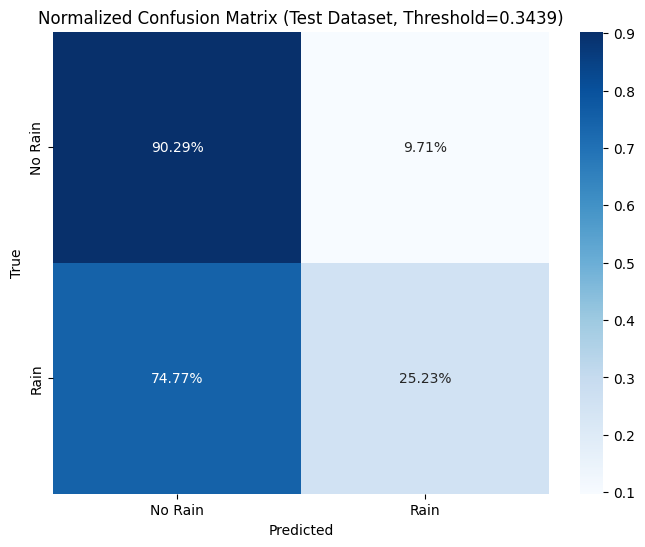

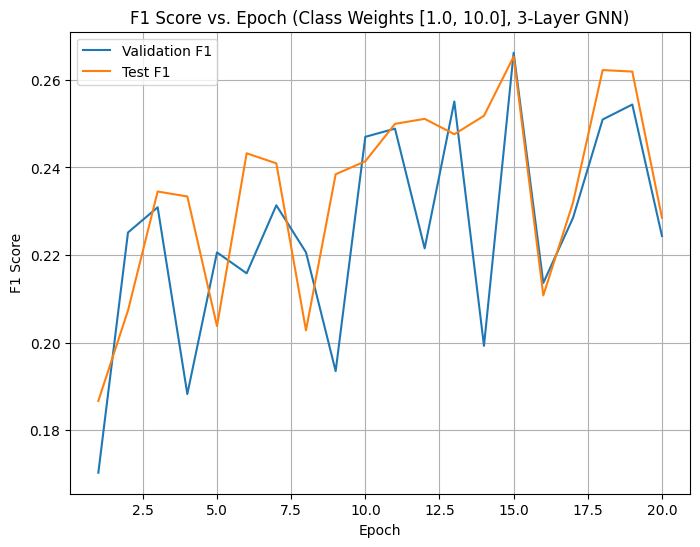

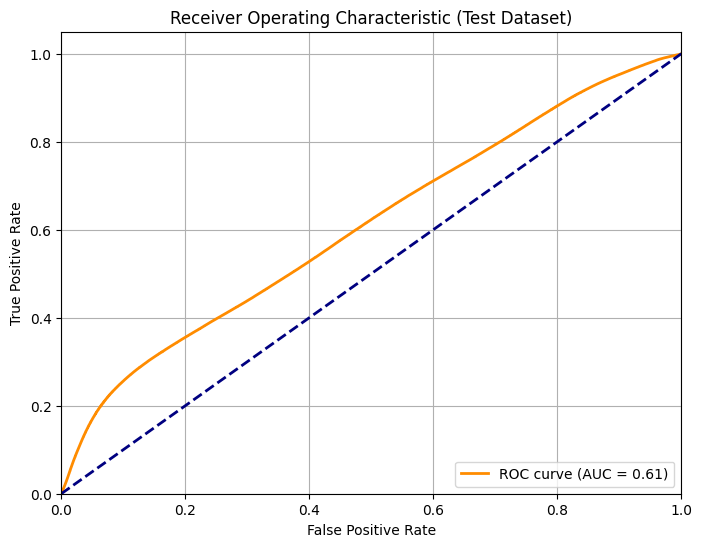

Test ROC AUC: 0.6074


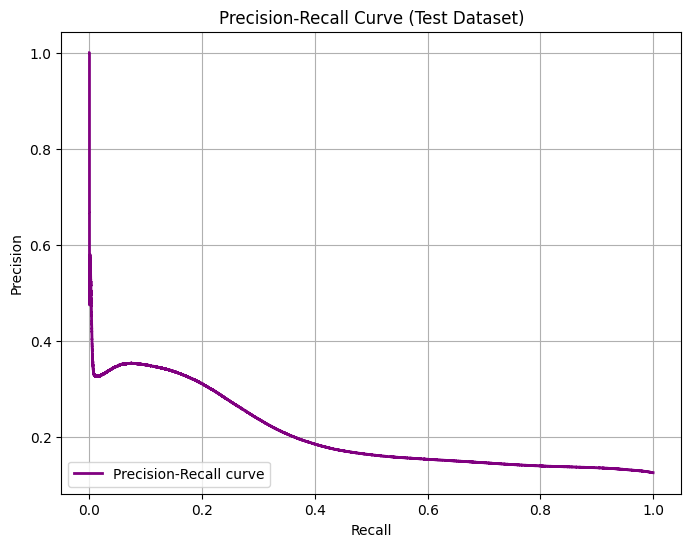

In [15]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title(f'Normalized Confusion Matrix (Test Dataset, Threshold={best_threshold:.4f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()

# F1 Score Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1')
plt.plot(range(1, len(test_f1_scores) + 1), test_f1_scores, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epoch (Class Weights [1.0, 10.0], 3-Layer GNN)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/f1_score_epochs.png')
plt.show()


# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Dataset)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/roc_curve.png')
plt.show()
print(f"Test ROC AUC: {roc_auc:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Dataset)')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/precision_recall_curve.png')
plt.show()

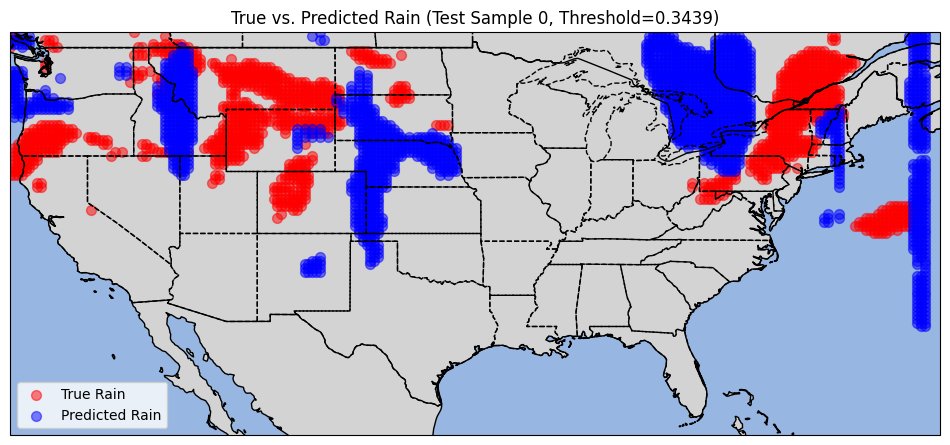

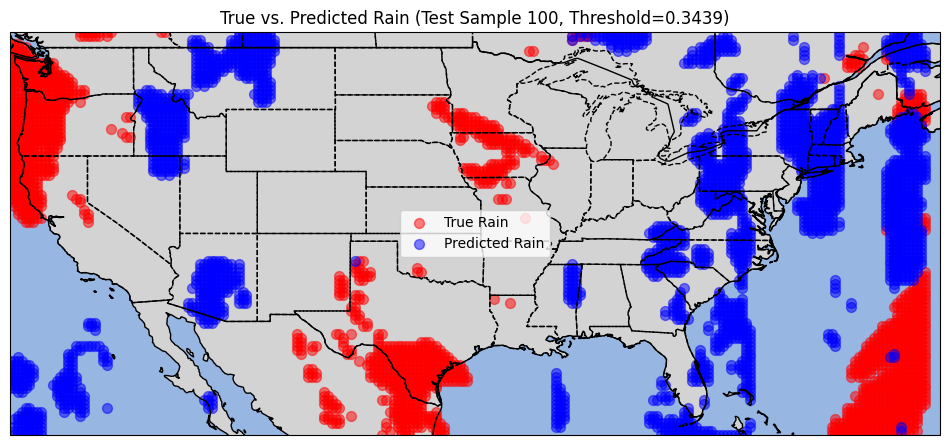

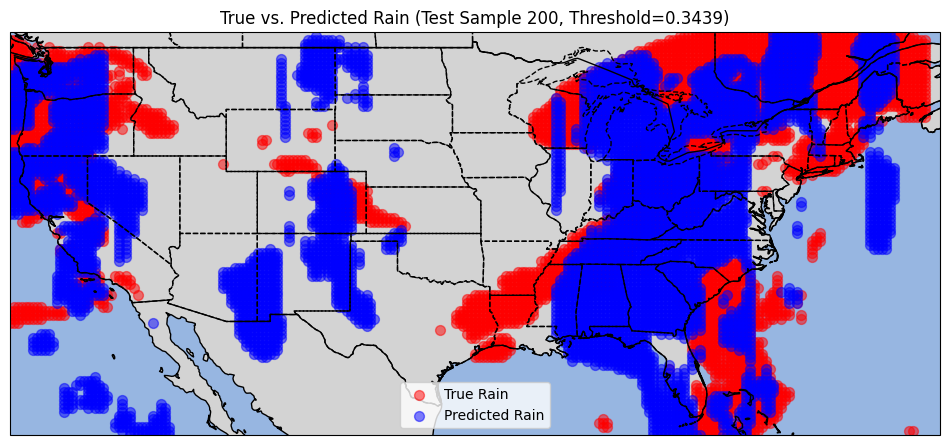

In [26]:
# Spatial Map Comparison for Selected Test Samples
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
test_sample_indices = [0,100, 200]  # Modify this list to compare different samples
for test_sample_idx in test_sample_indices:
    if test_sample_idx >= len(test_dataset):
        print(f"Skipping index {test_sample_idx}: Out of bounds (max {len(test_dataset)-1})")
        continue
    data = test_dataset[test_sample_idx]
    with torch.no_grad():
        data = data.to(device)
        out = model(data)
        probs = torch.softmax(out, dim=1)[:, 1]
        preds = (probs >= best_threshold).float()
    preds = preds.cpu().numpy().reshape(N_lat, N_lon)
    true = data.y.cpu().numpy().reshape(N_lat, N_lon)

    #Spatial Map
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([235, 295, 24, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle='--')
    true_rain = np.where(true == 1)
    ax.scatter(lon_mesh[true_rain], lat_mesh[true_rain], c='red', s=50, alpha=0.5, label='True Rain', transform=ccrs.PlateCarree())
    pred_rain = np.where(preds == 1)
    ax.scatter(lon_mesh[pred_rain], lat_mesh[pred_rain], c='blue', s=50, alpha=0.5, label='Predicted Rain', transform=ccrs.PlateCarree())
    plt.title(f'True vs. Predicted Rain (Test Sample {test_sample_idx}, Threshold={best_threshold:.4f})')
    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/spatial_prediction_{test_sample_idx}.png')
    plt.show()